# Spread Analysis

Author: Ansel Cheung Heng Yu

This notebook's main goal is to explore how movie embeddings are shifting/spreading over the years. Our main hypothesis is that movies are becoming more and more "similar". One example is how the Fast and Furious franchise has shifted from actual car and racing to brain dead action and explosions. However on hindsight, this could be loaded with bias because of the movies that we watch, e.g. mainly Hollywood movies. 

Here we explore spread via 3 main metrics: 
1. Mean L2 Norm
2. Frobenius Norm
3. Spectral Norm

## Imports and data loading

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

notebook_dir = Path().resolve()
base_path = os.path.abspath(notebook_dir.parent.parent)
sys.path.append(base_path)
from src.utils.data_utils import *

In [4]:
data_path = os.path.join(base_path, "data", "data_final")
csv_path = os.path.join(data_path, "final_dataset.csv")

In [5]:
ratings_path = os.path.join(data_path, "title_ratings.tsv")

In [6]:
ratings_df = pd.read_csv(ratings_path, delimiter="\t")

In [7]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614513 entries, 0 to 1614512
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1614513 non-null  object 
 1   averageRating  1614513 non-null  float64
 2   numVotes       1614513 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 37.0+ MB


In [8]:
ratings_df.rename(columns={"tconst": "imdb_id"}, inplace=True)

In [9]:
df = load_final_data_with_embeddings(csv_path, data_path, verbose=False)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92374 entries, 0 to 92373
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   movie_id                       92374 non-null  object 
 1   country                        91534 non-null  object 
 2   imdb_id                        91006 non-null  object 
 3   duration                       57734 non-null  float64
 4   duration_all                   57734 non-null  object 
 5   actors_id                      75496 non-null  object 
 6   actors                         75496 non-null  object 
 7   directors_id                   86598 non-null  object 
 8   directors                      86598 non-null  object 
 9   genre_id                       80918 non-null  object 
 10  genre                          80884 non-null  object 
 11  release_date                   92374 non-null  object 
 12  wikidata_class                 92374 non-null 

In [11]:
df = pd.merge(df, ratings_df, on="imdb_id", how="left")

In [12]:
df = df.filter([
    "movie_id", 
    "title",
    "plot",
    "year",
    "directors",
    "averageRating",
    "numVotes",
    "embedding",
    "genre",
    "new_genre",
    "country",
])

In [14]:
# Label the new genres
with open(os.path.join(base_path, "src", "config", "cluster_to_genre_mapping_01122025.json"), "r") as f:
    genre_fix_mapping = json.load(f)

df = df[(df["new_genre"] != "Unknown") & (df["new_genre"].notna())].reset_index(drop=True)
df["new_genre"] = df["new_genre"].apply(lambda x: [genre_fix_mapping[i] for i in x.split("|")])

In [15]:
df.shape

(79984, 11)

In [16]:
df.head()

,movie_id,title,plot,year,directors,averageRating,numVotes,embedding,genre,new_genre,country
0,Q158047,The Blue Angel,Immanuel Rath is a professor at the local Gymn...,1930,Josef von Sternberg,7.6,17396.0,"[-0.04922, 0.0475, 0.003048, -0.011536, -0.020...","drama film, film based on literature",[drama],Germany
1,Q166089,Abraham Lincoln,The first act of the film covers Lincoln's ear...,1930,D. W. Griffith,5.7,1848.0,"[-0.012054, 0.0181, -0.04782, 0.01465, -0.0224...","drama film, war film, biographical film, histo...","[drama, family youth and war, biographical]",United States
2,Q185214,Anna Christie,"Chris Christofferson (George F. Marion), the a...",1930,Clarence Brown,6.5,3765.0,"[-0.01281, -0.011314, -0.04633, -0.001071, -0....","drama film, romance film","[drama, romance]",United States
3,Q272599,All Quiet on the Western Front,Early in World War I Professor Kantorek gives ...,1930,Lewis Milestone,8.1,71265.0,"[-0.01184, 0.0401, -0.03577, -0.002903, 0.0011...","drama film, war film, film based on a novel","[drama, family youth and war]",United States
4,Q531332,The Big House,"Kent (Robert Montgomery), a drunk driver who c...",1930,George W. Hill,7.1,2879.0,"[-0.01392, -0.003054, -0.00642, -0.01338, -0.0...","drama film, prison film, crime film, romance film","[drama, romance, action crime and exploitation...",United States


## Overall Scatter/Cloud analysis

Using Mean L2 Norm of yearly centered embeddings (embedding - yearly_centroid)

In [17]:
years = np.arange(df.year.min(), df.year.max() + 1)
yearly_spread_l2 = []
for year in years:
    year_df = df[df.year==year].sample(300)
    year_embedding = np.stack(year_df.embedding.values)
    centroid = year_embedding.mean(axis=0)

    # L2 norm
    l2_norms = np.linalg.norm(year_embedding - centroid, axis=1)
    mean_l2_norm = l2_norms.mean()
    yearly_spread_l2.append(float(mean_l2_norm))

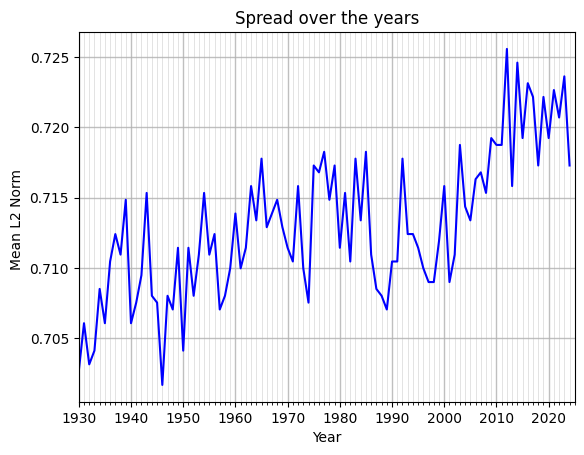

In [18]:
fig, ax = plt.subplots()
ax.plot(years, yearly_spread_l2, color="b")
ax.set_title("Spread over the years")
ax.set_xlabel("Year")
ax.set_ylabel("Mean L2 Norm ")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
ax.set_xlim([1930, 2025])
plt.show();

This is the mean L2 distance, group size normalized, interpretable as Intra Year Dispersion. This graph shows that the dispersion compared intra years is very constant throught out time. Values of l2 distance can range from 2 to 0, since $\|u - v\|^2 = \|u\|^2 + \|v\|^2 - 2(u\cdot v) = 1 + 1 - 2(u\cdot v) = 2 - 2(u\cdot v)$ and $u\cdot v$ is cosine distance which we showed ranges from 0 to around 1. 

Next question to ask is, since the intra year spread is not shifting, is the INTER year spread increasing? let us explore the L2 norm of the centroid

In [ ]:
years = np.arange(df.year.min(), df.year.max() + 1)
yearly_centroid_l2 = []
for year in years:
    year_df = df[df.year==year].sample(300)
    year_embedding = np.stack(year_df.embedding.values)
    centroid = year_embedding.mean(axis=0)

    # centroid L2
    l2_norm = np.linalg.norm(centroid)
    yearly_centroid_l2.append(float(l2_norm))

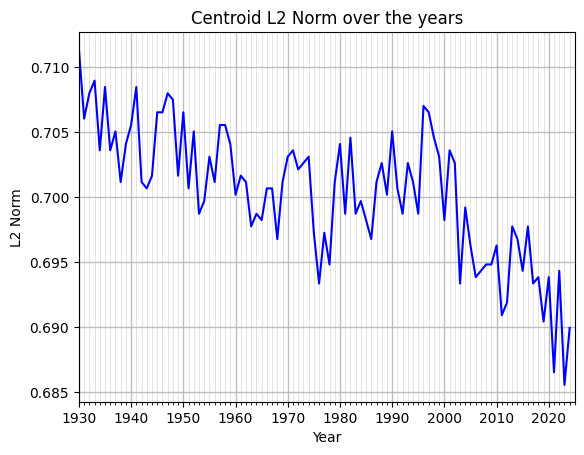

In [ ]:
fig, ax = plt.subplots()
ax.plot(years, yearly_centroid_l2, color="b")
ax.set_title("Centroid L2 Norm over the years")
ax.set_xlabel("Year")
ax.set_ylabel("L2 Norm")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
ax.set_xlim([1930, 2025])
plt.show();

L2 norm of the centroid also shows that the centroid itself is not changing much and have a relatively low "diversity" along the 1024 axis. There is no "polarizing" axis which is growing stronger and stronger.

Next we wanted to go back and analyze the spread even more. First we analyzed the variance $\mathbb{E}[\|x_i - \text{centroid}\|^2]$ of each embedding to the centroid for each year. Normalized group size of 300.

We also analyzed the first prinicpal component, what we hypothesized to be the most polarizing dimension or axis along the embedding. We used the Spectral norm which is the Standard Deviation along the first principal component.

$$\|X - centroid\|_2 = \sqrt{\lambda_{max}(X - centroid)^\top(X - centroid)}$$

In [ ]:
years = np.arange(df.year.min(), df.year.max() + 1)
yearly_spread_frobenius = []
yearly_spread_spectral = []

for year in years:
    year_df = df[df.year==year].sample(300)
    year_embedding = np.stack(year_df.embedding.values).astype(np.float32)
    centroid = year_embedding.mean(axis=0)

    # L2 norm
    centered_embeddings = year_embedding - centroid
    # centered_embeddings = year_embedding
    frobenius_norm = np.linalg.norm(centered_embeddings, ord='fro')
    yearly_spread_frobenius.append(float(frobenius_norm))

    # Spectral norm (largest singular value of the centered embedding matrix)
    spectral_norm = np.linalg.norm(centered_embeddings, ord=2)
    yearly_spread_spectral.append(float(spectral_norm))

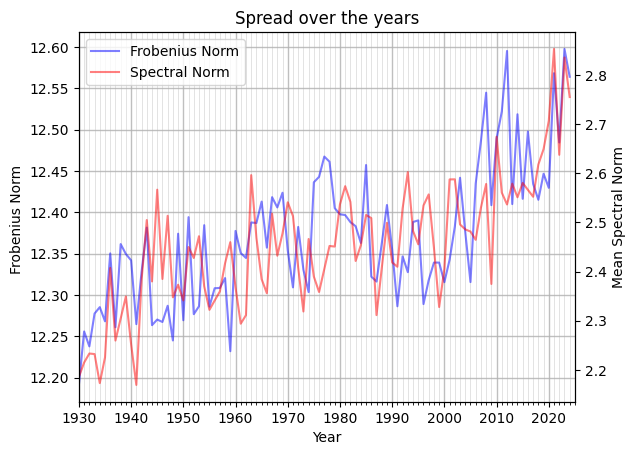

In [ ]:
fig, ax = plt.subplots()
ax.plot(years, yearly_spread_frobenius, color="b", alpha=0.5, label="Frobenius Norm")
ax.set_title("Spread over the years")
ax.set_xlabel("Year")
ax.set_ylabel("Frobenius Norm ")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
ax.set_xlim([1930, 2025])
ax2 = ax.twinx()
ax2.plot(years, yearly_spread_spectral, color="r", alpha=0.5, label="Spectral Norm")
ax2.set_ylabel("Mean Spectral Norm")

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
plt.show();

From the figure, we can see that both are increasing. 

Frobenius norm increasing: The embeddings within each year are becoming more dispersed from their centroid in squared-distance terms.
Larger deviations dominate: Because of squaring distances, this metric is more sensitive to outliers or extreme points. A few embeddings very far from the centroid contribute disproportionately. If Frobenius increases but mean distance stays relatively flat, it suggests there are more outliers or long-tail dispersion rather than uniform spreading.

Spectral norm increasing: The year's embeddings are becoming more spread out along their primary axis of variation. There's an increasing "stretch" in whatever semantic direction exhibits the most variance. The dominant pattern/theme in your embeddings is becoming more pronounced or polarized.

Overall, the movies are spreading out both overall (Frobenius) and especially along the dominant semantic axis (spectral).

In [ ]:
# Boot strap test to see if change is significant
spectral_bootstrap_values = []
frobenius_bootstrap_values = []
for year in years:
    spectral_values = []
    frobenius_values = []
    year_df = df[df.year==year]
    for i in range(100):  # 1000 bootstrap samples
        sample = year_df.sample(len(year_df), replace=True)
        sample_embeddings = np.stack(sample.embedding.values).astype(np.float32)
        centroid = sample_embeddings.mean(axis=0)
        centered_embeddings = sample_embeddings - centroid

        # Frobenius norm
        frobenius_norm = np.linalg.norm(centered_embeddings, ord='fro')
        frobenius_values.append(float(frobenius_norm))

        # Spectral norm
        spectral_norm = np.linalg.norm(centered_embeddings, ord=2)
        spectral_values.append(float(spectral_norm))
    
    frob_ci_lower = np.percentile(frobenius_values, 2.5)
    frob_ci_upper = np.percentile(frobenius_values, 97.5)
    frobenius_bootstrap_values.append((frob_ci_lower, frob_ci_upper))

    spec_ci_lower = np.percentile(spectral_values, 2.5)
    spec_ci_upper = np.percentile(spectral_values, 97.5)
    spectral_bootstrap_values.append((spec_ci_lower, spec_ci_upper))

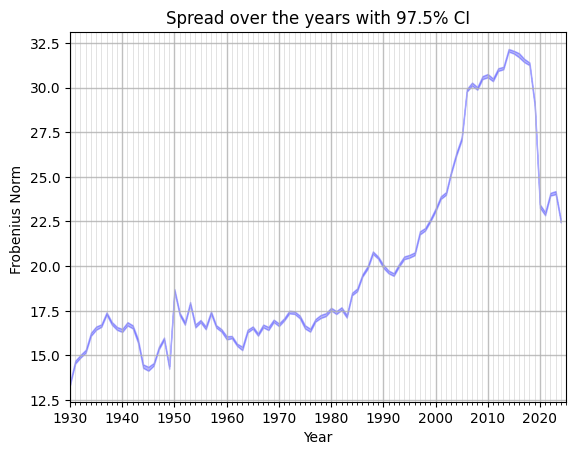

In [ ]:
fig, ax = plt.subplots()
ax.fill_between(years, [ci[0] for ci in frobenius_bootstrap_values], [ci[1] for ci in frobenius_bootstrap_values], color="b", alpha=0.3, label="Frobenius Norm CI")
ax.set_title("Spread over the years with 97.5% CI")
ax.set_xlabel("Year")
ax.set_ylabel("Frobenius Norm ")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
ax.set_xlim([1930, 2025])
plt.show();

## Analysis of first PC (explained variance)

Percentage of explained variance: $$\frac{\|X - centroid\|^2_2}{\|X - centroid\|^2_F} = \frac{\sigma_1^2}{\sigma_1^2 + \dots + \sigma_r^2}$$

Now that we know that the overall mean of movie embeddings is not changing much, but somehow the frobenius and spectral norm of the difference between movies and their yearly norms are increasing, this means that the tail end movies are becoming more spread out. Especially along some principal component for each year. 

The next question we had was "what does each year's principal component tell us about the movies?".

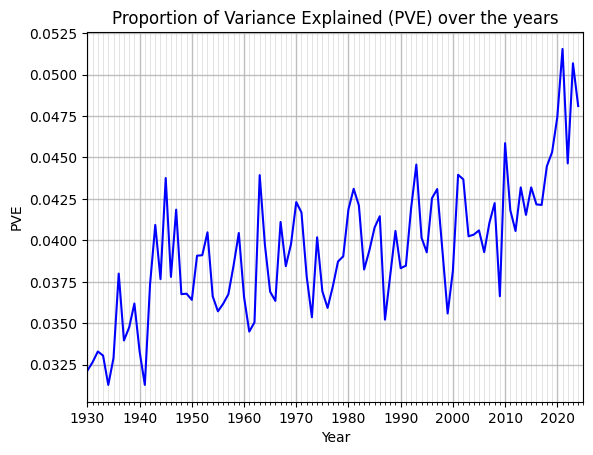

In [ ]:
yearly_pve = np.array(yearly_spread_spectral)**2/np.array(yearly_spread_frobenius)**2

# Plot yearly PVE over the years
fig, ax = plt.subplots()
ax.plot(years, yearly_pve, color="blue")
ax.set_title("Proportion of Variance Explained (PVE) over the years")
ax.set_xlabel("Year")
ax.set_ylabel("PVE")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
ax.set_xlim([1930, 2025])
plt.show();

Interpretation: 
Variance is concentrating into fewer dimensions
The semantic variation is becoming more structured or polarized


In [ ]:
from sklearn.decomposition import PCA

pca_df = pd.DataFrame({"ranking": [1,2,3,4,5,-5,-4,-3,-2,-1], "label": ["Top 1","Top 2","Top 3","Top 4","Top 5","Bottom 5","Bottom 4","Bottom 3","Bottom 2","Bottom 1"]})
for year in [1949, 1970, 2001, 2020, 2024]:
    year_df = df[df.year==year]
    pca = PCA(n_components=1)
    pcaed_embeddings = pca.fit_transform(np.stack(year_df.embedding.values).astype(np.float32)).reshape(-1)
    top5 = np.argpartition(pcaed_embeddings.reshape(-1), -5)[-5:]
    bottom5 = np.argpartition(pcaed_embeddings.reshape(-1), 5)[:5]
    pca_df[f"{year}_title"] = year_df.iloc[np.hstack([top5, bottom5])].title.tolist()
    pca_df[f"{year}_genre"] = year_df.iloc[np.hstack([top5, bottom5])].new_genre.apply(lambda x: ",".join(x)).tolist()

In [ ]:
pca_df

,ranking,label,1949_title,1949_genre,1970_title,1970_genre,2001_title,2001_genre,2020_title,2020_genre,2024_title,2024_genre
0,1,Top 1,La Cuna vacía,"family youth and war,drama",Many Wars Ago,"family youth and war,drama",The Profit,drama,Freaky,"horror and scifi,comedy",The Thundermans Return,"action western and international,comedy,crime ..."
1,2,Top 2,Nilam,drama,Paths of War,"comedy,adventure music and diverse,action west...",Valley of the T-Rex,documentary experimental and film history,The Boy Behind the Door,"horror and scifi,crime and thriller",Smile 2,"horror and scifi,crime and thriller"
2,3,Top 3,Wings of Youth,"comedy,drama",The Last Escape,"crime and thriller,action western and internat...",Osmosis Jones,"comedy,action western and international,family...",Psych 2: Lassie Come Home,comedy,Beetlejuice Beetlejuice,"comedy,satire and dark comedy,fantasy and scif..."
3,4,Top 4,"Corrientes, calle de ensueños",musical,Underground,"family youth and war,drama",The Lost Battalion,"family youth and war,drama",Tremors: Shrieker Island,"documentary experimental and film history,acti...",It’s What’s Inside,comedy
4,5,Top 5,Barsaat,"romance,drama","Rosolino Paternò, soldato...","comedy,family youth and war",Frailty,"horror and scifi,crime and thriller",Run Sweetheart Run,horror and scifi,Terrifier 3,horror and scifi
5,-5,Bottom 5,"Arson, Inc.",crime and thriller,Naya Raasta,drama,Piriyadha Varam Vendum,"romance,family youth and war",Dear Future Children,documentary experimental and film history,My Place Is Here,drama
6,-4,Bottom 4,White Heat,"adventure music and diverse,action western and...",Dharma Daata,drama,Tera Mera Saath Rahen,drama,Khorfakkan,drama,Season of Love,romance
7,-3,Bottom 3,"Abbott and Costello Meet the Killer, Boris Kar...","comedy,fantasy and scifi,crime and thriller",Khilona,drama,Hridoyer Bandhon,romance,Before the Dying of the Light,documentary experimental and film history,And Their Children After Them,"family youth and war,drama"
8,-2,Bottom 2,The Window,"film noir,action western and international,drama",Maattukara Velan,drama,Narasimha Naidu,drama,The Europeans,romance,Alone in the Night,comedy
9,-1,Bottom 1,The Third Man,"adventure music and diverse,film noir,crime an...",Kodalu Diddina Kapuram,drama,Super Kudumbam,comedy,Neighborhood Cinemas,documentary experimental and film history,Tears of Cem Karaca,biographical


In [ ]:
# Now only look at US Movies

us_pca_df = pd.DataFrame({"ranking": [1,2,3,4,5,-5,-4,-3,-2,-1], "label": ["Top 1","Top 2","Top 3","Top 4","Top 5","Bottom 5","Bottom 4","Bottom 3","Bottom 2","Bottom 1"]})
for year in [1952, 1974, 2003, 2024]:
    year_df = df[(df.year==year)]
    pca = PCA(n_components=1)
    pcaed_embeddings = pca.fit_transform(np.stack(year_df.embedding.values).astype(np.float32)).reshape(-1)
    year_df["pca"] = pcaed_embeddings
    year_df = year_df[year_df["country"].apply(lambda x: "United States" in x if isinstance(x, str) else False)]
    year_df = year_df.sort_values(by="pca", ascending=False).reset_index(drop=True)
    us_pca_df[f"{year}_title"] = year_df.head(5).title.tolist() + year_df.tail(5).title.tolist()
    us_pca_df[f"{year}_genre"] = year_df.head(5).new_genre.tolist() + year_df.tail(5).new_genre.tolist()

In [ ]:
us_pca_df

,ranking,label,1952_title,1952_genre,1974_title,1974_genre,2003_title,2003_genre,2024_title,2024_genre
0,1,Top 1,Monsoon,[drama],Gone in 60 Seconds,"[crime and thriller, action western and intern...",Aileen: Life and Death of a Serial Killer,"[documentary experimental and film history, cr...",Terrifier 3,[horror and scifi]
1,2,Top 2,Strange Fascination,"[film noir, drama]",Dark Star,"[comedy, adventure music and diverse, fantasy ...",Whole,[documentary experimental and film history],It’s What’s Inside,[comedy]
2,3,Top 3,No Time for Flowers,[romance],The Parallax View,[crime and thriller],Ghosts of the Abyss,[documentary experimental and film history],Beetlejuice Beetlejuice,"[comedy, satire and dark comedy, fantasy and s..."
3,4,Top 4,Just Across the Street,[comedy],The Towering Inferno,"[crime and thriller, action western and intern...",DC 9/11: Time of Crisis,[drama],Smile 2,"[horror and scifi, crime and thriller]"
4,5,Top 5,Everything I Have Is Yours,"[romance, musical]",Chinatown,"[film noir, crime and thriller, drama]",Marion's Triumph,[documentary experimental and film history],The Thundermans Return,"[action western and international, comedy, cri..."
5,-5,Bottom 5,Bend of the River,[action western and international],Great Expectations,[drama],Sinbad: Legend of the Seven Seas,"[adventure music and diverse, action western a...",The Firing Squad,"[adventure music and diverse, documentary anim..."
6,-4,Bottom 4,Denver and Rio Grande,[action western and international],The Story of Jacob and Joseph,[drama],The One,[romance],The True Story of Tamara de Lempicka and The A...,[documentary experimental and film history]
7,-3,Bottom 3,Red Skies of Montana,[action western and international],Little House on the Prairie,"[fantasy and scifi, biographical]",The Jungle Book 2,"[comedy, adventure music and diverse, musical,...",Harvest,[drama]
8,-2,Bottom 2,The Savage,[action western and international],Punch and Jody,[drama],Cosmopolitan,"[comedy, romance]",Waltzing with Brando,[biographical]
9,-1,Bottom 1,The Cimarron Kid,[action western and international],Claudine,"[comedy, romance, drama]",Flavors,[romance],Putin,"[crime and thriller, action western and intern..."


We decide to use US movies and german movies because of the target audience of this report. These are movies which we know.

In 1930, be said that one end of the axis is drama, family, war, while on the other end is romance.

In 2020 and 2024, we can see how that axis has changed to become one of horror and thriller opposing with documentary and biographies.

In [ ]:
# Now only look at German Movies

german_pca_df = pd.DataFrame({"ranking": [1,2,3,4,5,-5,-4,-3,-2,-1], "label": ["Top 1","Top 2","Top 3","Top 4","Top 5","Bottom 5","Bottom 4","Bottom 3","Bottom 2","Bottom 1"]})
for year in [1952, 1974, 2003, 2024]:
    year_df = df[(df.year==year)]
    pca = PCA(n_components=1)
    pcaed_embeddings = pca.fit_transform(np.stack(year_df.embedding.values).astype(np.float32)).reshape(-1)
    year_df["pca"] = pcaed_embeddings
    year_df = year_df[year_df["country"].apply(lambda x: "Germany" in x if isinstance(x, str) else False)]
    year_df = year_df.sort_values(by="pca", ascending=False).reset_index(drop=True)
    german_pca_df[f"{year}_title"] = year_df.head(5).title.tolist() + year_df.tail(5).title.tolist()
    german_pca_df[f"{year}_genre"] = year_df.head(5).new_genre.tolist() + year_df.tail(5).new_genre.tolist()

In [ ]:
german_pca_df

,ranking,label,1952_title,1952_genre,1974_title,1974_genre,2003_title,2003_genre,2024_title,2024_genre
0,1,Top 1,Lockende Sterne,[drama],The Internecine Project,[crime and thriller],Beyond the Limits,[horror and scifi],The Devil's Bath,"[horror and scifi, crime and thriller, drama]"
1,2,Top 2,We're Dancing on the Rainbow,[musical],Lisa and the Devil,"[horror and scifi, crime and thriller, action ...",Nikos the Impaler,[horror and scifi],Bird,[drama]
2,3,Top 3,The Colourful Dream,[musical],The Odessa File,"[crime and thriller, drama]",Baltic Storm,"[crime and thriller, drama]",A Sacrifice,"[crime and thriller, drama]"
3,4,Top 4,Rosen blühen auf dem Heidegrab,[drama],Challenge to White Fang,"[adventure music and diverse, action western a...",Debris documentar,"[horror and scifi, drama]",Cuckoo,"[horror and scifi, crime and thriller]"
4,5,Top 5,Das kann jedem passieren,[comedy],Alice in the Cities,"[action western and international, drama]",Wrong Turn,"[horror and scifi, crime and thriller, action ...",Santosh,[crime and thriller]
5,-5,Bottom 5,Toxi,[drama],Effi Briest,[drama],The Suit,"[comedy, drama]",Every You Every Me,"[romance, drama]"
6,-4,Bottom 4,The Condemned Village,[documentary experimental and film history],The Enigma of Kaspar Hauser,"[biographical, drama]",Noi the Albino,"[comedy, drama]",Spy vs. Spy,"[adventure music and diverse, crime and thrill..."
7,-3,Bottom 3,My Name is Niki,"[comedy, drama]",Virgins of the Seven Seas,[action western and international],The Story of the Weeping Camel,[drama],The Empire,[fantasy and scifi]
8,-2,Bottom 2,The Thief of Bagdad,[musical],Supermarket,"[action western and international, drama]",A Little Bit of Freedom,[drama],Rabia,"[crime and thriller, drama]"
9,-1,Bottom 1,All Clues Lead to Berlin,"[crime and thriller, drama]",Ali: Fear Eats the Soul,"[romance, action western and international, dr...","Spring, Summer, Fall, Winter... and Spring",[drama],Harvest,[drama]


## PCA variance

In [ ]:
# Yearly PCA 

num_pcs_for_95_ex_var = []
for year in years:
    year_df = df[(df.year==year)].sample(300, random_state=42)
    pca = PCA(n_components=0.95)
    pca.fit(np.stack(year_df.embedding.values).astype(np.float32))
    num_pcs_for_95_ex_var.append(pca.n_components_)

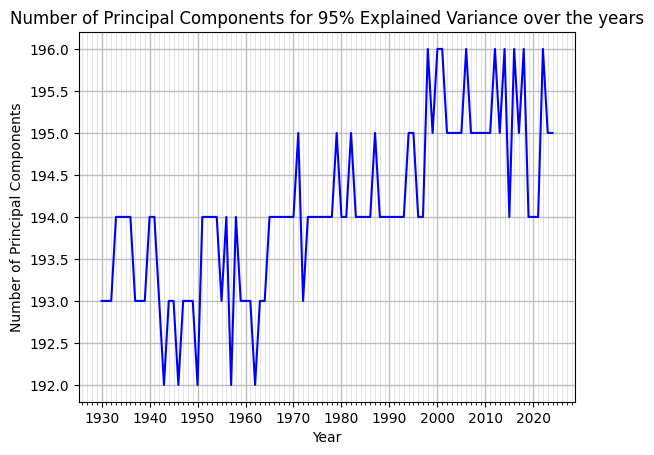

In [ ]:
fig, ax = plt.subplots()
ax.plot(years, num_pcs_for_95_ex_var, color="b")
ax.set_title("Number of Principal Components for 95% Explained Variance over the years")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Principal Components")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
ax.grid(which="minor", linewidth=0.5, alpha=0.5)
plt.show();

In [ ]:
# Decade PCA 

num_pcs_for_95_ex_var = []
for year in [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]:
    year_df = df[(df.year>= year) & (df.year < year + 10)].sample(1000, random_state=42)
    pca = PCA(n_components=0.95)
    pca.fit(np.stack(year_df.embedding.values).astype(np.float32))
    num_pcs_for_95_ex_var.append(pca.n_components_)

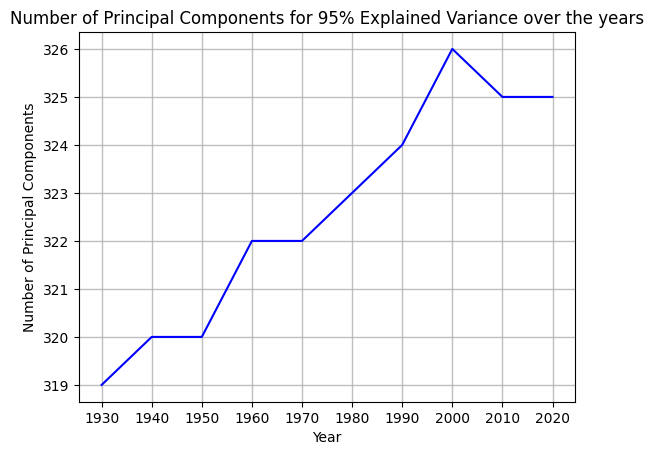

In [ ]:
fig, ax = plt.subplots()
ax.plot([1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020], num_pcs_for_95_ex_var, color="b")
ax.set_title("Number of Principal Components for 95% Explained Variance over the years")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Principal Components")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
# ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.grid(which="major", linewidth=1, alpha=0.8)
# ax.grid(which="minor", linewidth=0.5, alpha=0.5)
plt.show();